# Clase 7 — Fundamentos IA: Estadística aplicada con Python

Este notebook está diseñado para usar en clase: incluye **muchos ejemplos**, explicaciones en Markdown y código listo para ejecutar. 
Contenidos:

- Estadística descriptiva (media, mediana, moda, varianza, desviación estándar, rango)
- Medidas de posición (cuartiles, percentiles)
- Distribuciones (normal, sesgada, bimodal, uniforme)
- Correlaciones y visualizaciones
- Correlación vs causalidad
- Detección e interpretación de outliers
- Caso práctico: E-commerce (ventas vs publicidad)

Ejecuta las celdas en orden. Todas las gráficas usan `matplotlib` (sin especificar colores) para garantizar consistencia didáctica.


In [2]:
! pip install pandas
! pip install seaborn
! pip install matplotlib
! pip install scipy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Ajustes visuales mínimos
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['font.size'] = 12

print('librerías cargadas')

librerías cargadas


# Ejemplo exploración

In [16]:
import pandas as pd

# Creamos un dataset pequeño
data = {
    "Mes": ["Enero", "Enero", "Febrero", "Febrero", "Marzo", "Marzo", "Enero"],
    "Vendedor": ["Ana", "Luis", "Ana", "Luis", "Ana", "Luis", "Ana"],
    "Ventas": [12000, 15000, 13000, 16000, 12500, 15500, 14000],
    "Productos_Vendidos": [120, 135, 125, 140, 130, 138, 145],
    "Region": ["Norte", "Sur", "Norte", "Sur", "Norte", "Sur", "Norte"]
}

df = pd.DataFrame(data)
print(df)


       Mes Vendedor  Ventas  Productos_Vendidos Region
0    Enero      Ana   12000                 120  Norte
1    Enero     Luis   15000                 135    Sur
2  Febrero      Ana   13000                 125  Norte
3  Febrero     Luis   16000                 140    Sur
4    Marzo      Ana   12500                 130  Norte
5    Marzo     Luis   15500                 138    Sur
6    Enero      Ana   14000                 145  Norte


In [10]:

df.describe()

,Ventas,Productos_Vendidos
count,6.000000,6.000000
mean,14000.000000,131.333333
std,1702.938637,7.788881
min,12000.000000,120.000000
25%,12625.000000,126.250000
50%,14000.000000,132.500000
75%,15375.000000,137.250000
max,16000.000000,140.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Mes                 6 non-null      object
 1   Vendedor            6 non-null      object
 2   Ventas              6 non-null      int64 
 3   Productos_Vendidos  6 non-null      int64 
 4   Region              6 non-null      object
dtypes: int64(2), object(3)
memory usage: 372.0+ bytes


In [26]:
df.value_counts(subset=["Region"], normalize=True, ascending=True)

Region
Sur       0.428571
Norte     0.571429
Name: proportion, dtype: float64

In [31]:
resumen = df.groupby("Vendedor").agg({
    "Ventas": ["mean", "max", "min", "std", "sum"],
    "Productos_Vendidos": "mean"
})
print(resumen)
print(type(resumen))
# guardar dataframe en excel
resumen.to_excel("resumen_ventas.xlsx")

           Ventas                                  Productos_Vendidos
             mean    max    min         std    sum               mean
Vendedor                                                             
Ana       12875.0  14000  12000  853.912564  51500         130.000000
Luis      15500.0  16000  15000  500.000000  46500         137.666667
<class 'pandas.core.frame.DataFrame'>


## Dataset 1 — Salarios (ejemplo realista y pequeño)
Generaremos un dataset con variables típicas: `salario_kusd` (miles USD), `edad`, `experiencia_anios`, `nivel_educativo` (categoría), `departamento` (categoría).

In [36]:
# ============================================
# 📊 Generación de un dataset sintético de salarios
# ============================================

import numpy as np
import pandas as pd

# Fijamos una semilla para asegurar que los resultados sean reproducibles
np.random.seed(42)

# Número de registros o empleados simulados
N = 2000

# --------------------------------------------
# 🧍 Edad de los empleados
# --------------------------------------------
# Generamos edades con distribución normal (media=35, desviación=8)
# Se convierte a entero para que no haya decimales
edad = np.random.normal(35, 8, N).astype(int)

# --------------------------------------------
# 💼 Años de experiencia
# --------------------------------------------
# Suponemos que las personas empiezan a trabajar a los 22 años.
# Calculamos la experiencia como (edad - 22), con un poco de variabilidad aleatoria (ruido)
# np.clip asegura que no haya valores negativos.
experiencia = np.clip((edad - 22) + np.random.normal(0, 3, N), 0, None).round(1)

# --------------------------------------------
# 🎓 Nivel educativo
# --------------------------------------------
# Asignamos niveles educativos de forma aleatoria, con diferentes probabilidades.
nivel_edu = np.random.choice(
    ['Bachiller', 'Pregrado', 'Posgrado'],
    size=N,
    p=[0.15, 0.65, 0.20]
)

# --------------------------------------------
# 💰 Cálculo del salario base
# --------------------------------------------
# Partimos de un salario base de 20 mil USD.
# Cada año de experiencia aumenta el salario en 1.3 mil USD.
# Además, se agrega un bono adicional según el nivel educativo:
#   - Bachiller: +0
#   - Pregrado: +5
#   - Posgrado: +12
salario_kusd = 20 + experiencia * 1.3 + (
    np.where(nivel_edu == 'Pregrado', 5,
             np.where(nivel_edu == 'Posgrado', 12, 0))
)

# --------------------------------------------
# 🔊 Añadimos ruido y valores atípicos (outliers)
# --------------------------------------------
# Agregamos un ruido aleatorio normal (media=0, desviación=5)
salario_kusd = salario_kusd + np.random.normal(0, 5, N)

# Introducimos manualmente algunos outliers:
salario_kusd[5] = 120  # Un salario extremadamente alto
salario_kusd[12] = 5   # Un salario inusualmente bajo

# --------------------------------------------
# 🏢 Asignación de departamento
# --------------------------------------------
# Cada empleado pertenece a uno de los siguientes departamentos:
departamento = np.random.choice(
    ['Ventas', 'TI', 'Operaciones', 'Marketing'],
    size=N
)

# --------------------------------------------
# 📋 Creación del DataFrame final
# --------------------------------------------
df_sal = pd.DataFrame({
    'salario_kusd': np.round(salario_kusd, 2),
    'edad': edad,
    'experiencia_anios': experiencia,
    'nivel_educativo': nivel_edu,
    'departamento': departamento
})

# Mostramos las primeras filas del dataset
df_sal.head()


,salario_kusd,edad,experiencia_anios,nivel_educativo,departamento
0,39.86,38,14.0,Pregrado,TI
1,34.75,33,10.6,Bachiller,Ventas
2,45.54,40,15.6,Posgrado,TI
3,56.41,47,24.1,Pregrado,TI
4,41.39,33,5.3,Pregrado,Marketing


### Estadística descriptiva — ejemplos
Calcularemos media, mediana, moda, rango, varianza y desviación estándar. Interpretaremos diferencias entre media y mediana.

In [37]:
# ============================================
# Estadísticos descriptivos básicos del salario
# ============================================

# Calculamos un resumen estadístico general
stats_sal = df_sal['salario_kusd'].describe()

# Medidas de tendencia central
media = df_sal['salario_kusd'].mean()
mediana = df_sal['salario_kusd'].median()
moda = df_sal['salario_kusd'].mode().iloc[0]

# Medidas de dispersión
varianza = df_sal['salario_kusd'].var()
desv_std = df_sal['salario_kusd'].std()
rango = df_sal['salario_kusd'].max() - df_sal['salario_kusd'].min()

# --------------------------------------------
# Impresión de resultados
# --------------------------------------------

print("============================================")
print(" ANÁLISIS DESCRIPTIVO DE LOS SALARIOS (en miles de USD)")
print("============================================\n")

print("Resumen estadístico general:")
print(stats_sal)
print("\n--------------------------------------------")
print(f"Media: {media:.2f}")
print(f"Mediana: {mediana:.2f}")
print(f"Moda: {moda:.2f}")
print("--------------------------------------------")
print(f"Varianza: {varianza:.2f}")
print(f"Desviación estándar: {desv_std:.2f}")
print(f"Rango (máx - mín): {rango:.2f}")
print("============================================")


 ANÁLISIS DESCRIPTIVO DE LOS SALARIOS (en miles de USD)

Resumen estadístico general:
count    2000.000000
mean       42.522735
std        12.256675
min         5.000000
25%        34.100000
50%        42.090000
75%        50.607500
max       120.000000
Name: salario_kusd, dtype: float64

--------------------------------------------
Media: 42.52
Mediana: 42.09
Moda: 41.29
--------------------------------------------
Varianza: 150.23
Desviación estándar: 12.26
Rango (máx - mín): 115.00


### Visualizaciones: Histograma y boxplot
Mostraremos la forma de la distribución y detectaremos outliers con boxplot.

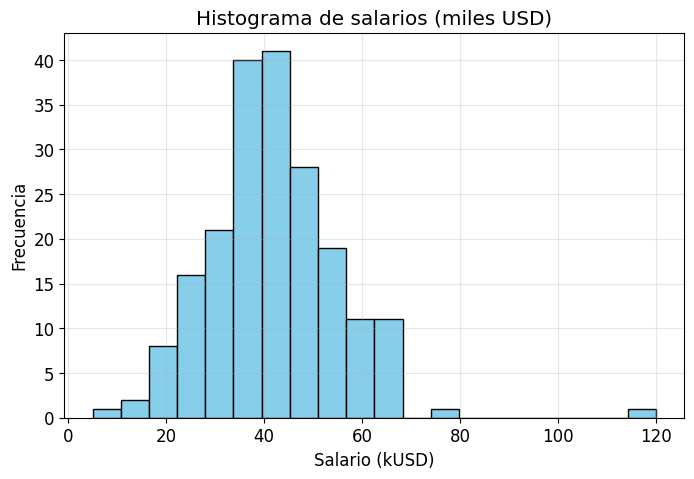

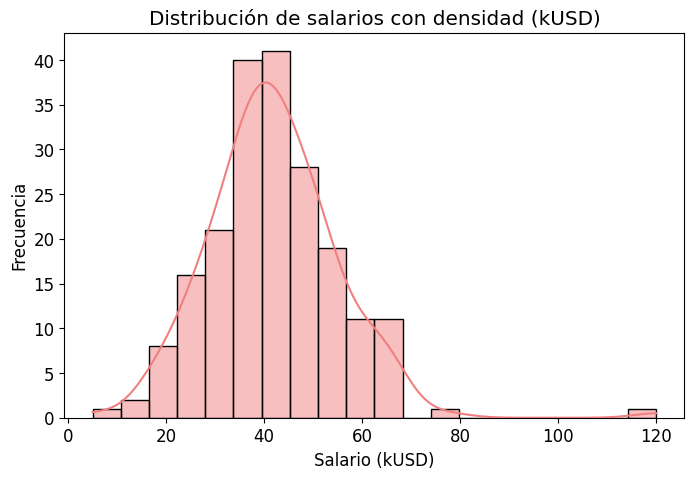

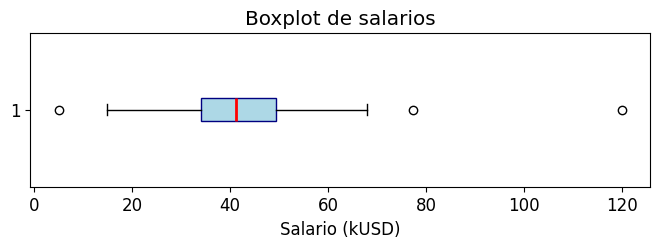

/var/folders/19/5cy24wkj2tj9z31t2rs3mmc00000gn/T/ipykernel_12218/498533965.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='nivel_educativo', y='salario_kusd', data=df_sal, palette='pastel')


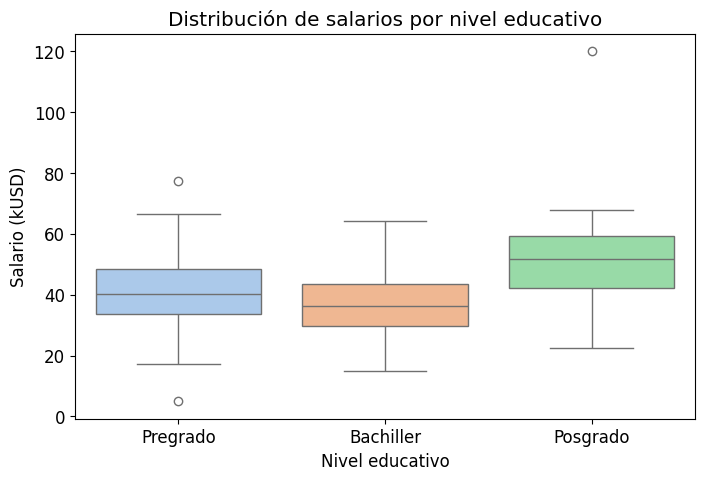

/var/folders/19/5cy24wkj2tj9z31t2rs3mmc00000gn/T/ipykernel_12218/498533965.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='nivel_educativo', y='salario_kusd', data=df_sal, palette='muted')


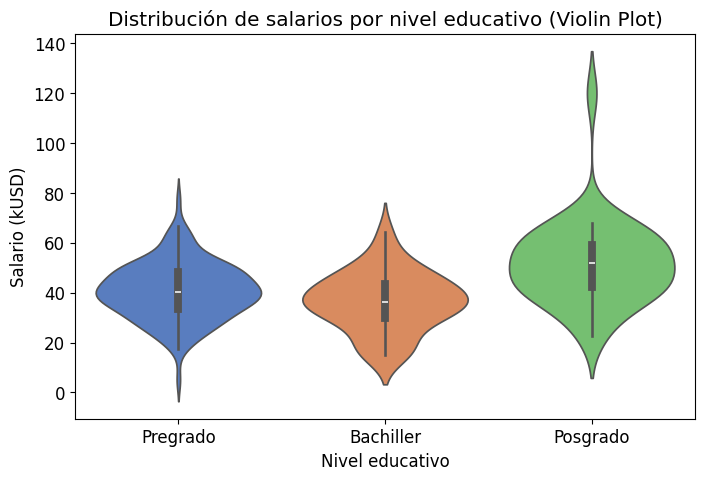

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================
# Visualización de la distribución de salarios
# ============================================

# ------------------------------------------------
# 1️⃣ Histograma clásico con Matplotlib
# ------------------------------------------------
plt.figure(figsize=(8,5))
plt.hist(df_sal['salario_kusd'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histograma de salarios (miles USD)')
plt.xlabel('Salario (kUSD)')
plt.ylabel('Frecuencia')
plt.grid(alpha=0.3)
plt.show()

# Explicación:
# - El histograma muestra cuántos empleados están dentro de cada rango de salario.
# - Permite observar la forma de la distribución (simétrica, sesgada, multimodal, etc.).
# - Los "bins" (intervalos) determinan el nivel de detalle del gráfico.


# ------------------------------------------------
# 2️⃣ Histograma con línea de densidad (Seaborn)
# ------------------------------------------------
plt.figure(figsize=(8,5))
sns.histplot(df_sal['salario_kusd'], bins=20, kde=True, color='lightcoral')
plt.title('Distribución de salarios con densidad (kUSD)')
plt.xlabel('Salario (kUSD)')
plt.ylabel('Frecuencia')
plt.show()

# Explicación:
# - Seaborn agrega la curva de densidad (línea suave), útil para ver la tendencia general.
# - Es una forma más elegante de visualizar distribuciones continuas.
# - La curva KDE (Kernel Density Estimate) suaviza las frecuencias.


# ------------------------------------------------
# 3️⃣ Boxplot horizontal con Matplotlib
# ------------------------------------------------
plt.figure(figsize=(8,2))
plt.boxplot(df_sal['salario_kusd'], vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='navy'),
            medianprops=dict(color='red', linewidth=2))
plt.title('Boxplot de salarios')
plt.xlabel('Salario (kUSD)')
plt.show()

# Explicación:
# - El boxplot (diagrama de caja) muestra la mediana, los cuartiles y los valores atípicos (outliers).
# - La línea roja indica la mediana.
# - Los puntos fuera de los "bigotes" son valores atípicos (salarios inusualmente altos o bajos).


# ------------------------------------------------
# 4️⃣ Boxplot comparativo por nivel educativo (Seaborn)
# ------------------------------------------------
plt.figure(figsize=(8,5))
sns.boxplot(x='nivel_educativo', y='salario_kusd', data=df_sal, palette='pastel')
plt.title('Distribución de salarios por nivel educativo')
plt.xlabel('Nivel educativo')
plt.ylabel('Salario (kUSD)')
plt.show()

# Explicación:
# - Permite comparar cómo varía la distribución del salario entre distintos niveles educativos.
# - Se observan las medianas, la dispersión y la presencia de outliers en cada grupo.


# ------------------------------------------------
# 5️⃣ Violin plot (alternativa avanzada)
# ------------------------------------------------
plt.figure(figsize=(8,5))
sns.violinplot(x='nivel_educativo', y='salario_kusd', data=df_sal, palette='muted')
plt.title('Distribución de salarios por nivel educativo (Violin Plot)')
plt.xlabel('Nivel educativo')
plt.ylabel('Salario (kUSD)')
plt.show()

# Explicación:
# - Combina las características del boxplot con la forma de la densidad.
# - Muestra claramente si la distribución es simétrica o sesgada dentro de cada grupo.


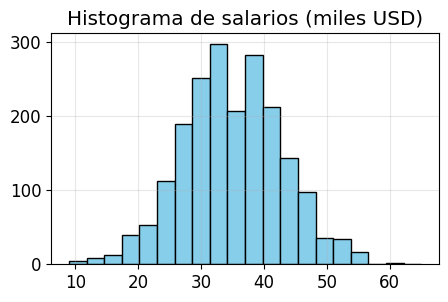

In [ ]:
plt.figure(figsize=(5,3))
plt.hist(df_sal['edad'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histograma de salarios (miles USD)')
plt.xlabel('Salario (kUSD)')
plt.ylabel('Frecuencia')
plt.grid(alpha=0.3)
plt.show()


**Interpretación — Media vs Mediana**

- Cuando existe un outlier (por ejemplo un salario extremadamente alto), la **media** se desplaza hacia ese valor mientras que la **mediana** se mantiene más robusta.
- Siempre reportar ambas métricas si la distribución no es simétrica.

In [23]:
# ============================================
# Comparación de medidas de tendencia central y dispersión
# ============================================

# Forma tradicional y clara
print("============================================")
print(" RESUMEN DE MEDIDAS ESTADÍSTICAS DEL SALARIO ")
print("============================================")
print(f"Media (promedio):        {media:.2f} kUSD")
print(f"Mediana (valor central): {mediana:.2f} kUSD")
print(f"Moda (valor más común):  {moda:.2f} kUSD")
print("--------------------------------------------")
print(f"Rango (máx - mín):       {rango:.2f} kUSD")
print(f"Desviación estándar:     {desv_std:.2f} kUSD")
print("============================================\n")

# --------------------------------------------
# Alternativa 1: mostrarlo como tabla formateada
# --------------------------------------------
print("Versión en tabla:")
print(pd.DataFrame({
    'Estadístico': ['Media', 'Mediana', 'Moda', 'Rango', 'Desv. estándar'],
    'Valor (kUSD)': [media, mediana, moda, rango, desv_std]
}).round(2))
print()

# --------------------------------------------
# Alternativa 2: usar f-strings con formato visual
# --------------------------------------------
print(f"""
Resumen numérico de los salarios (en miles de USD):

- Media (promedio general):        {media:.2f}
- Mediana (valor central):         {mediana:.2f}
- Moda (valor más frecuente):      {moda:.2f}
- Rango (diferencia máx - mín):    {rango:.2f}
- Desviación estándar (variabilidad): {desv_std:.2f}
""")


 RESUMEN DE MEDIDAS ESTADÍSTICAS DEL SALARIO 
Media (promedio):        41.89 kUSD
Mediana (valor central): 41.17 kUSD
Moda (valor más común):  36.63 kUSD
--------------------------------------------
Rango (máx - mín):       115.00 kUSD
Desviación estándar:     13.34 kUSD

Versión en tabla:
      Estadístico  Valor (kUSD)
0           Media         41.89
1         Mediana         41.17
2            Moda         36.63
3           Rango        115.00
4  Desv. estándar         13.34


Resumen numérico de los salarios (en miles de USD):

- Media (promedio general):        41.89
- Mediana (valor central):         41.17
- Moda (valor más frecuente):      36.63
- Rango (diferencia máx - mín):    115.00
- Desviación estándar (variabilidad): 13.34



### Medidas de posición: cuartiles y percentiles
Calcularemos cuartiles y percentiles y mostraremos ejemplos de interpretación.

In [24]:
# ============================================
# Cuartiles y percentiles del salario
# ============================================

# Cuartil 1 (Q1): el 25% de los salarios son menores o iguales a este valor.
q1 = df_sal['salario_kusd'].quantile(0.25)

# Cuartil 2 (Q2): equivale a la mediana, el 50% de los salarios están por debajo.
q2 = df_sal['salario_kusd'].quantile(0.50)

# Cuartil 3 (Q3): el 75% de los salarios están por debajo de este valor.
q3 = df_sal['salario_kusd'].quantile(0.75)

# Percentiles: permiten ver los valores en diferentes posiciones de la distribución
# Por ejemplo: P10, P25, P50, P75, P90
percentiles = df_sal['salario_kusd'].quantile([0.10, 0.25, 0.50, 0.75, 0.90])

# --------------------------------------------
# Impresión de resultados
# --------------------------------------------

print("============================================")
print(" CUARTILES Y PERCENTILES DEL SALARIO (kUSD)")
print("============================================")
print(f"Q1 (25%):  {q1:.2f} kUSD  → El 25% de los empleados gana menos de este valor.")
print(f"Q2 (50%):  {q2:.2f} kUSD  → Mediana, punto medio de la distribución.")
print(f"Q3 (75%):  {q3:.2f} kUSD  → El 75% de los empleados gana menos de este valor.")
print("--------------------------------------------")
print("Percentiles seleccionados:")
print(percentiles.round(2))
print("============================================")


 CUARTILES Y PERCENTILES DEL SALARIO (kUSD)
Q1 (25%):  34.15 kUSD  → El 25% de los empleados gana menos de este valor.
Q2 (50%):  41.17 kUSD  → Mediana, punto medio de la distribución.
Q3 (75%):  49.37 kUSD  → El 75% de los empleados gana menos de este valor.
--------------------------------------------
Percentiles seleccionados:
0.10    26.27
0.25    34.15
0.50    41.17
0.75    49.37
0.90    58.09
Name: salario_kusd, dtype: float64


## Tipos de distribuciones — ejemplos sintéticos
Generaremos datos sintéticos para ver claramente: normal, sesgada a la derecha, bimodal y uniforme.

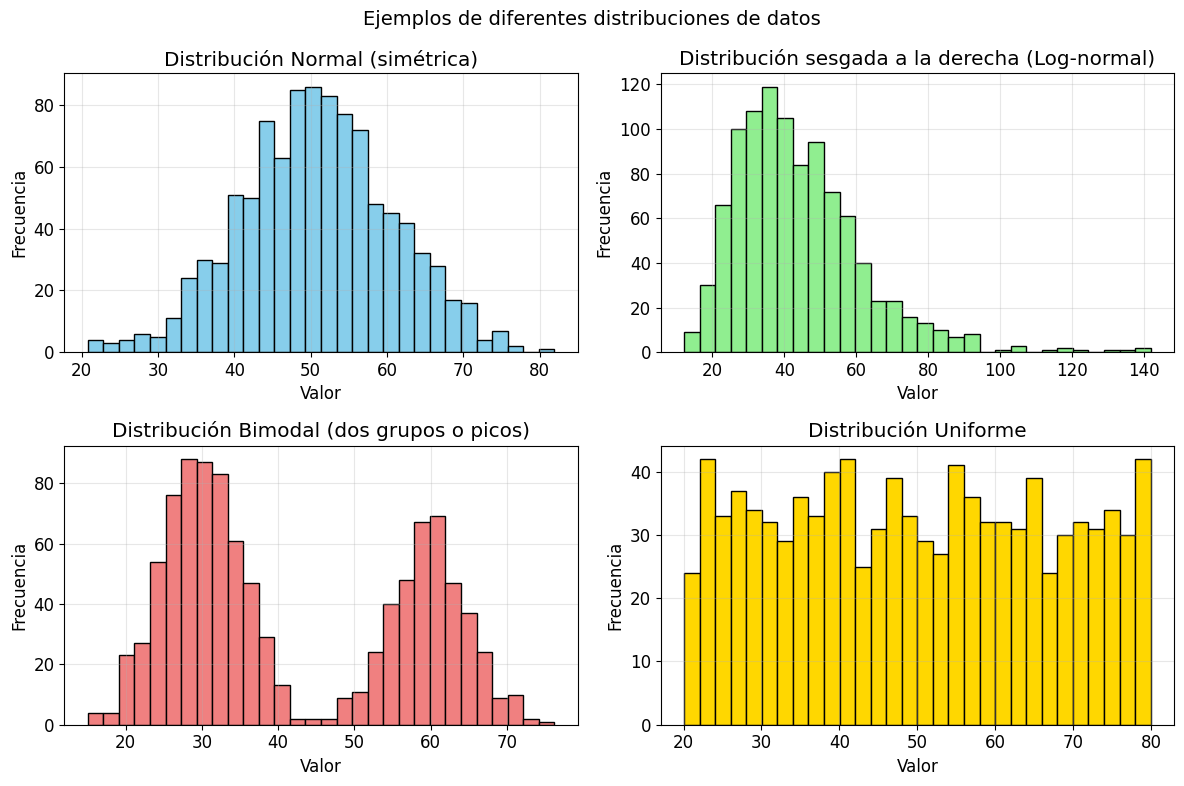

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# Diferentes tipos de distribuciones de datos
# ============================================

# Distribución normal (simétrica)
# Media = 50, Desviación estándar = 10
x_norm = np.random.normal(50, 10, 1000)

# Distribución sesgada a la derecha (log-normal)
# La mayoría de los valores son bajos, pero existen algunos muy altos (cola a la derecha)
x_right = np.random.lognormal(mean=3.7, sigma=0.4, size=1000)

# Distribución bimodal (dos picos)
# Mezcla de dos normales: una centrada en 30 y otra en 60
x_bimodal = np.concatenate([
    np.random.normal(30, 5, 600),
    np.random.normal(60, 5, 400)
])

# Distribución uniforme
# Todos los valores entre 20 y 80 son igualmente probables
x_unif = np.random.uniform(20, 80, 1000)

# ============================================
# Visualización comparativa
# ============================================

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.ravel()

# Histograma Normal
axs[0].hist(x_norm, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Distribución Normal (simétrica)')

# Histograma Log-normal (sesgada a la derecha)
axs[1].hist(x_right, bins=30, color='lightgreen', edgecolor='black')
axs[1].set_title('Distribución sesgada a la derecha (Log-normal)')

# Histograma Bimodal
axs[2].hist(x_bimodal, bins=30, color='lightcoral', edgecolor='black')
axs[2].set_title('Distribución Bimodal (dos grupos o picos)')

# Histograma Uniforme
axs[3].hist(x_unif, bins=30, color='gold', edgecolor='black')
axs[3].set_title('Distribución Uniforme')

# Ajustes generales de los ejes
for ax in axs:
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frecuencia')
    ax.grid(alpha=0.3)

plt.suptitle('Ejemplos de diferentes distribuciones de datos', fontsize=14)
plt.tight_layout()
plt.show()


## Correlaciones — ejemplos y visualización
Calcularemos la matriz de correlación entre variables numéricas y mostraremos una visualización con `imshow` y barras de color.


📊 Matriz de correlación:

                  salario_kusd  experiencia_anos  edad  horas_trabajo  \
salario_kusd              1.00              0.94  0.08          -0.04   
experiencia_anos          0.94              1.00  0.07          -0.02   
edad                      0.08              0.07  1.00           0.05   
horas_trabajo            -0.04             -0.02  0.05           1.00   
proyectos                 0.06             -0.07 -0.05          -0.14   

                  proyectos  
salario_kusd           0.06  
experiencia_anos      -0.07  
edad                  -0.05  
horas_trabajo         -0.14  
proyectos              1.00  


/var/folders/19/5cy24wkj2tj9z31t2rs3mmc00000gn/T/ipykernel_10358/1163718772.py:43: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/alex_espinosa/Documents/New_order/Guayerd/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


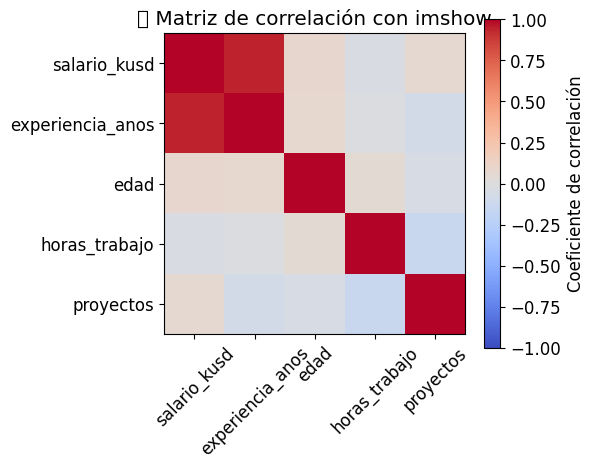

/Users/alex_espinosa/Documents/New_order/Guayerd/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


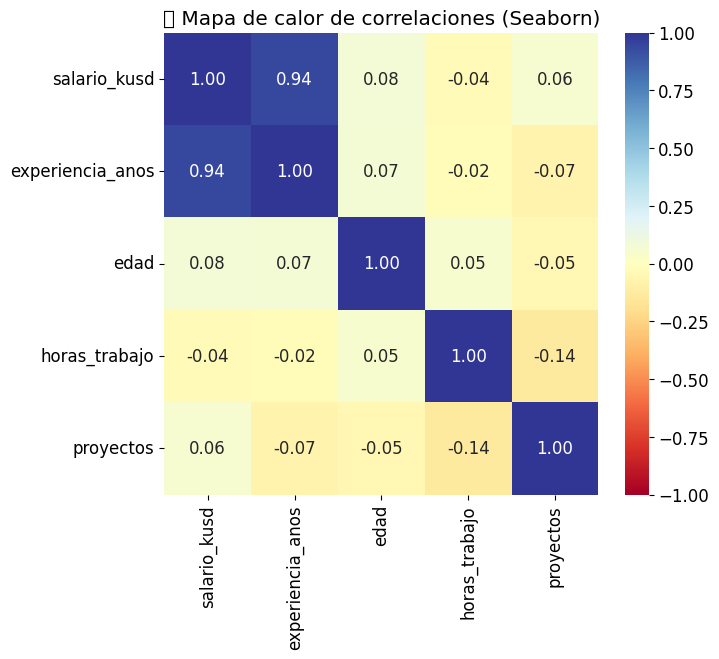

/Users/alex_espinosa/Documents/New_order/Guayerd/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


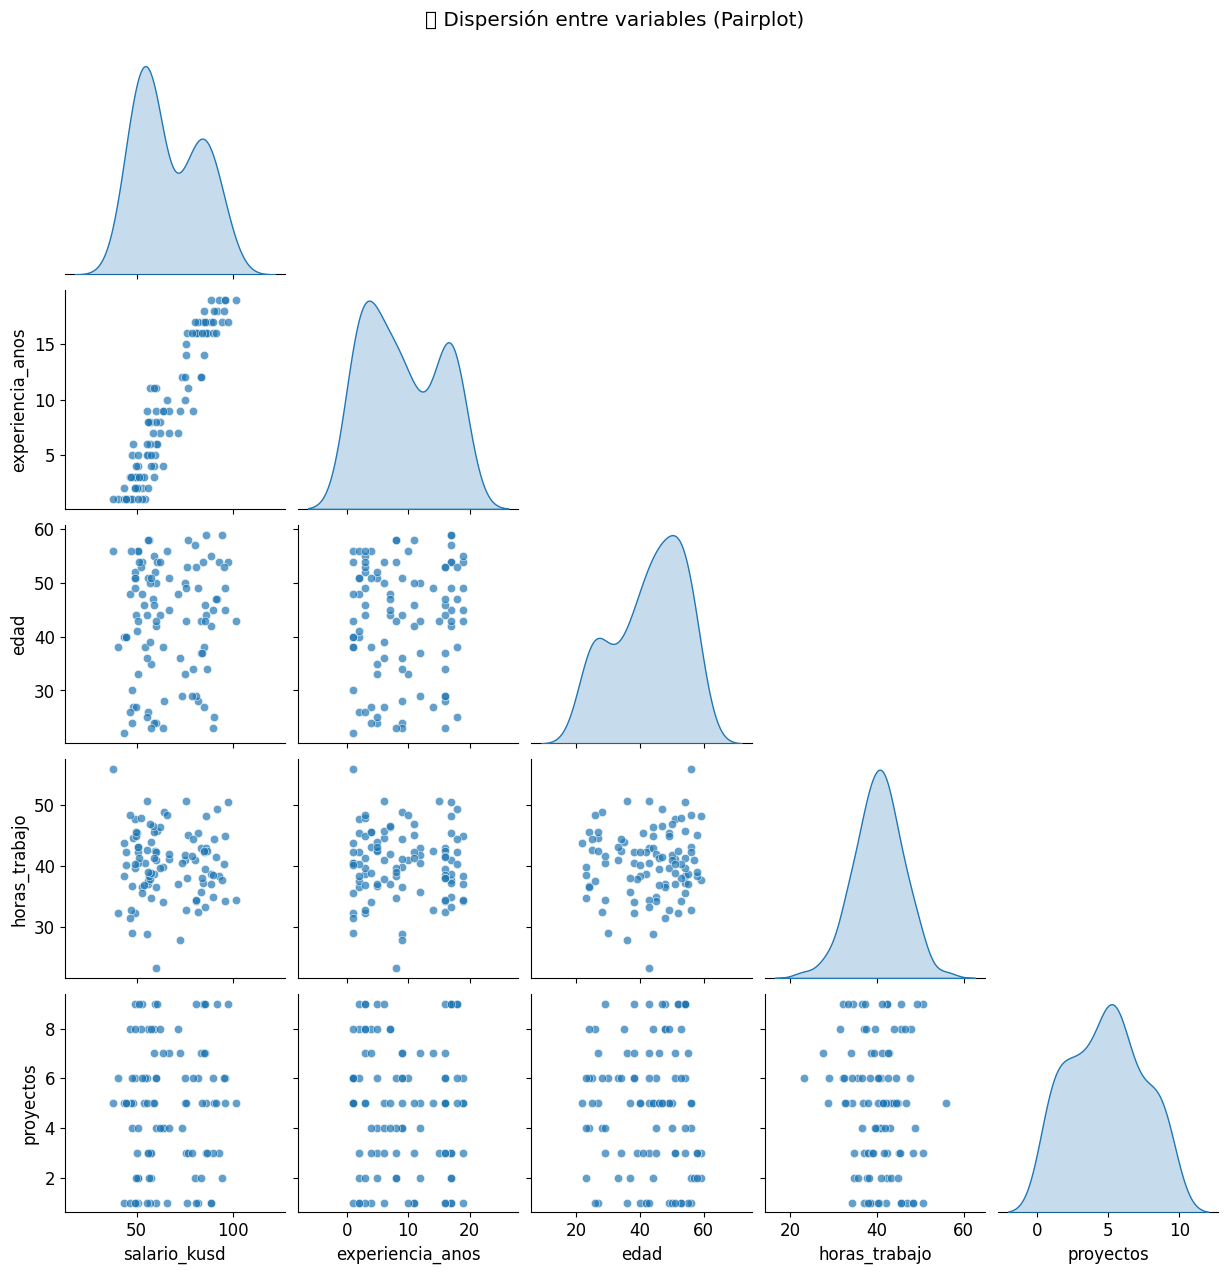

/var/folders/19/5cy24wkj2tj9z31t2rs3mmc00000gn/T/ipykernel_10358/1163718772.py:78: UserWarning: Glyph 128188 (\N{BRIEFCASE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/19/5cy24wkj2tj9z31t2rs3mmc00000gn/T/ipykernel_10358/1163718772.py:78: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/alex_espinosa/Documents/New_order/Guayerd/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128188 (\N{BRIEFCASE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/alex_espinosa/Documents/New_order/Guayerd/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


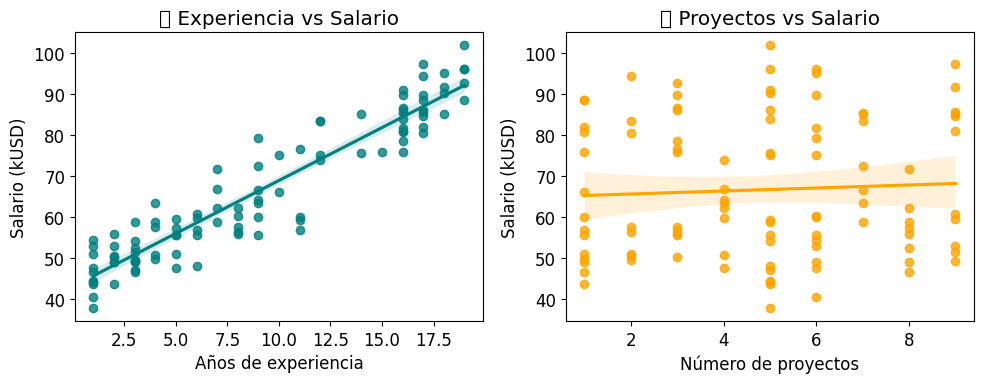

/Users/alex_espinosa/Documents/New_order/Guayerd/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


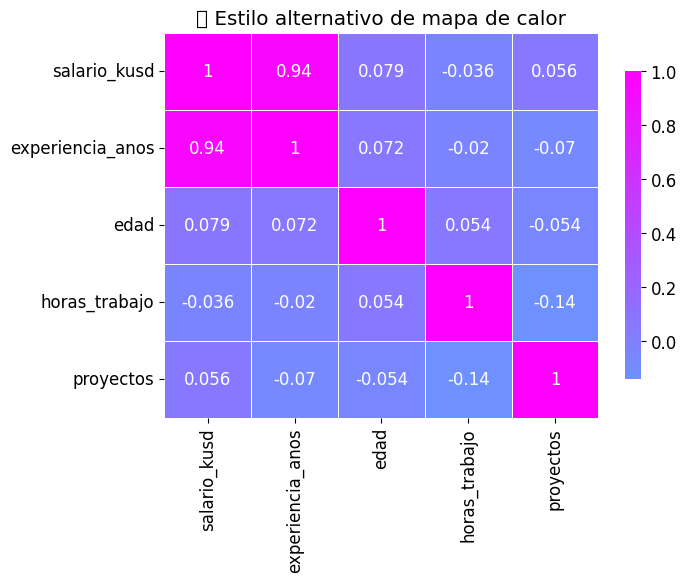

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Crear un dataset de ejemplo
np.random.seed(42)
n = 100

df_sal = pd.DataFrame({
    'salario_kusd': np.random.normal(50, 10, n),
    'experiencia_anos': np.random.randint(1, 20, n),
    'edad': np.random.randint(22, 60, n),
    'horas_trabajo': np.random.normal(40, 5, n),
    'proyectos': np.random.randint(1, 10, n)
})

# Añadimos una correlación artificial
df_sal['salario_kusd'] = (
    2.5 * df_sal['experiencia_anos'] +
    0.8 * df_sal['proyectos'] +
    np.random.normal(40, 5, n)
)

# ------------------------
# 1️⃣ Matriz de correlación numérica
# ------------------------
num_cols = df_sal.select_dtypes(include=[np.number])
cor_mat = num_cols.corr()

print("\n📊 Matriz de correlación:\n")
print(cor_mat.round(2))

# ------------------------
# 2️⃣ Visualización con imshow (básica)
# ------------------------
plt.figure(figsize=(6, 5))
plt.imshow(cor_mat, vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar(label='Coeficiente de correlación')
plt.xticks(range(len(cor_mat.columns)), cor_mat.columns, rotation=45)
plt.yticks(range(len(cor_mat.columns)), cor_mat.columns)
plt.title('🔥 Matriz de correlación con imshow')
plt.tight_layout()
plt.show()

# ------------------------
# 3️⃣ Heatmap con Seaborn (más elegante)
# ------------------------
plt.figure(figsize=(7, 6))
sns.heatmap(cor_mat, annot=True, cmap='RdYlBu', vmin=-1, vmax=1, fmt=".2f")
plt.title("💡 Mapa de calor de correlaciones (Seaborn)")
plt.show()

# ------------------------
# 4️⃣ Pairplot (relaciones visuales entre variables)
# ------------------------
sns.pairplot(df_sal, diag_kind='kde', corner=True, plot_kws={'alpha':0.7})
plt.suptitle("🔍 Dispersión entre variables (Pairplot)", y=1.02)
plt.show()

# ------------------------
# 5️⃣ Gráficos individuales de correlación
# ------------------------
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.regplot(x='experiencia_anos', y='salario_kusd', data=df_sal, color='teal')
plt.title("💼 Experiencia vs Salario")
plt.xlabel("Años de experiencia")
plt.ylabel("Salario (kUSD)")

plt.subplot(1,2,2)
sns.regplot(x='proyectos', y='salario_kusd', data=df_sal, color='orange')
plt.title("📈 Proyectos vs Salario")
plt.xlabel("Número de proyectos")
plt.ylabel("Salario (kUSD)")

plt.tight_layout()
plt.show()

# ------------------------
# 6️⃣ Mapa de calor estilo alternativo
# ------------------------
plt.figure(figsize=(7,5))
sns.heatmap(cor_mat, annot=True, cmap='cool', center=0, linewidths=0.5, cbar_kws={'shrink':.8})
plt.title("🎨 Estilo alternativo de mapa de calor")
plt.show()


In [31]:
df_sal.info()
# correlacion entre salarios y edad
correlacion = df_sal["salario_kusd"].corr(df_sal["edad"])
print("Correlación entre Salario y Edad:", correlacion)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   salario_kusd       200 non-null    float64
 1   edad               200 non-null    int64  
 2   experiencia_anios  200 non-null    float64
 3   nivel_educativo    200 non-null    object 
 4   departamento       200 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 7.9+ KB
Correlación entre Salario y Edad: 0.6934796825448118


### Correlación no implica causalidad — ejemplo con variable oculta
Crearemos un ejemplo simple donde dos variables están correlacionadas por una tercera variable latente (edad -> experiencia -> salario).


📊 MATRIZ DE CORRELACIÓN (variable latente):

             Edad  Experiencia  Salario
Edad         1.00         0.99     0.97
Experiencia  0.99         1.00     0.98
Salario      0.97         0.98     1.00


/Users/alex_espinosa/Documents/New_order/Guayerd/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


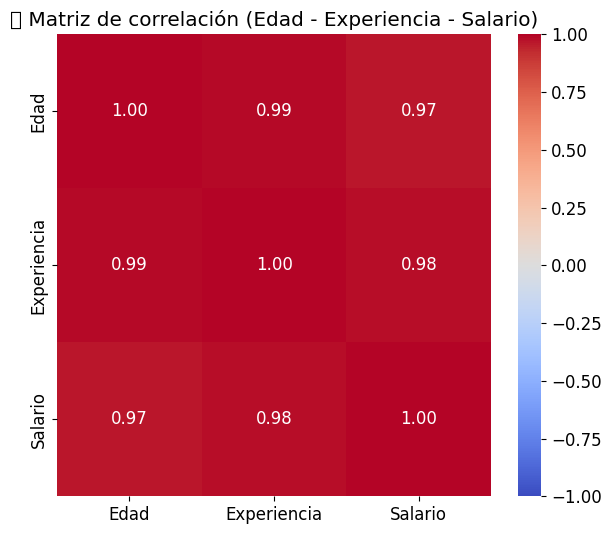

/var/folders/19/5cy24wkj2tj9z31t2rs3mmc00000gn/T/ipykernel_12218/193537656.py:54: UserWarning: Glyph 128116 (\N{OLDER MAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/19/5cy24wkj2tj9z31t2rs3mmc00000gn/T/ipykernel_12218/193537656.py:54: UserWarning: Glyph 128188 (\N{BRIEFCASE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/19/5cy24wkj2tj9z31t2rs3mmc00000gn/T/ipykernel_12218/193537656.py:54: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/alex_espinosa/Documents/New_order/Guayerd/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128116 (\N{OLDER MAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/alex_espinosa/Documents/New_order/Guayerd/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128188 (\N{BRIEFCASE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_fig

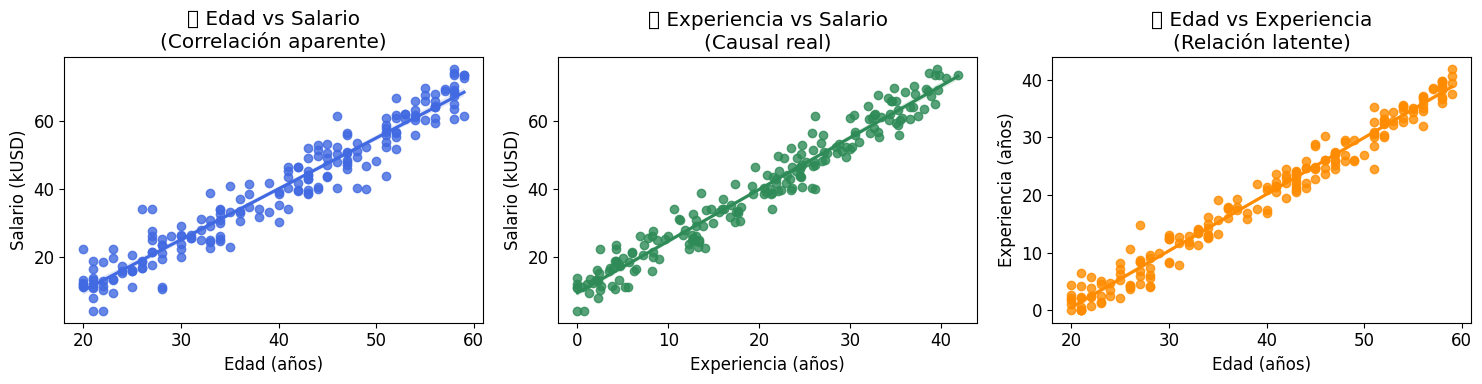


🧩 INTERPRETACIÓN:

Aunque 'Edad' y 'Salario' están correlacionadas (r > 0),
la relación NO es causal directa.

✅ La variable latente es 'Experiencia', que:
   - Está influenciada por la edad.
   - A su vez influye directamente en el salario.

📉 Conclusión:
   La correlación entre Edad y Salario es *espuria*,
   generada por la variable intermedia (Experiencia).



In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1️⃣ Generar datos simulados
# -----------------------------
np.random.seed(42)
A = np.random.randint(20, 60, 200)  # Edad
B = np.clip((A - 20) + np.random.normal(0, 2, 200), 0, None)  # Experiencia (depende de edad)
C = 10 + 1.5 * B + np.random.normal(0, 4, 200)  # Salario (depende de experiencia)

df_latent = pd.DataFrame({
    'Edad': A,
    'Experiencia': B,
    'Salario': C
})

# -----------------------------
# 2️⃣ Ver correlaciones numéricas
# -----------------------------
print("\n📊 MATRIZ DE CORRELACIÓN (variable latente):\n")
print(df_latent.corr().round(2))

# -----------------------------
# 3️⃣ Visualización de correlaciones
# -----------------------------
plt.figure(figsize=(7,6))
sns.heatmap(df_latent.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("🔥 Matriz de correlación (Edad - Experiencia - Salario)")
plt.show()

# -----------------------------
# 4️⃣ Visualizaciones individuales
# -----------------------------
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

sns.regplot(x='Edad', y='Salario', data=df_latent, ax=axs[0], color='royalblue')
axs[0].set_title("👴 Edad vs Salario\n(Correlación aparente)")
axs[0].set_xlabel("Edad (años)")
axs[0].set_ylabel("Salario (kUSD)")

sns.regplot(x='Experiencia', y='Salario', data=df_latent, ax=axs[1], color='seagreen')
axs[1].set_title("💼 Experiencia vs Salario\n(Causal real)")
axs[1].set_xlabel("Experiencia (años)")
axs[1].set_ylabel("Salario (kUSD)")

sns.regplot(x='Edad', y='Experiencia', data=df_latent, ax=axs[2], color='darkorange')
axs[2].set_title("📈 Edad vs Experiencia\n(Relación latente)")
axs[2].set_xlabel("Edad (años)")
axs[2].set_ylabel("Experiencia (años)")

plt.tight_layout()
plt.show()

# -----------------------------
# 5️⃣ Explicación textual
# -----------------------------
print("""
🧩 INTERPRETACIÓN:

Aunque 'Edad' y 'Salario' están correlacionadas (r > 0),
la relación NO es causal directa.

✅ La variable latente es 'Experiencia', que:
   - Está influenciada por la edad.
   - A su vez influye directamente en el salario.

📉 Conclusión:
   La correlación entre Edad y Salario es *espuria*,
   generada por la variable intermedia (Experiencia).
""")


## Detección de outliers — métodos prácticos
Mostraremos z-score y método IQR, y cómo documentar decisiones (eliminar o investigar).

Outliers detectados por Z-score (>3σ): 1


,salario_kusd,edad,experiencia_anios,nivel_educativo,departamento
5,120.0,33,8.2,Posgrado,Marketing


Outliers detectados por IQR: 3


,salario_kusd,edad,experiencia_anios,nivel_educativo,departamento
5,120.00,33,8.2,Posgrado,Marketing
12,5.00,36,16.9,Pregrado,Marketing
113,77.24,54,34.4,Pregrado,Ventas


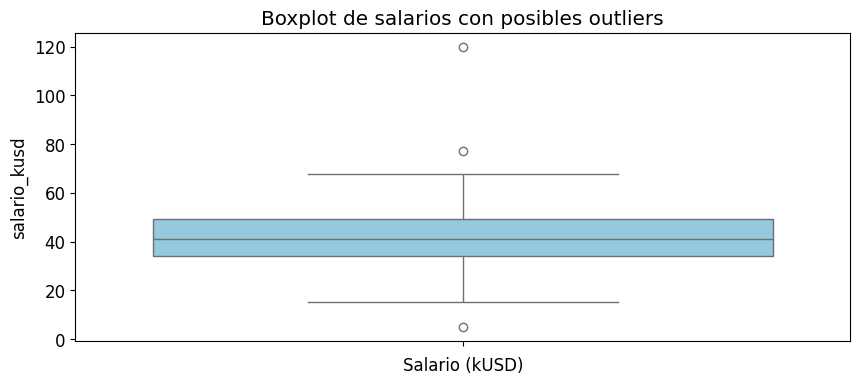


📘 INTERPRETACIÓN:

1. MÉTODO Z-SCORE:
   - Mide la distancia de cada dato respecto a la media en unidades de desviación estándar.
   - Si |z| > 3 → el punto está demasiado lejos del promedio.
   - Funciona bien cuando los datos siguen una distribución NORMAL.

2. MÉTODO IQR:
   - Usa los cuartiles (Q1 y Q3) para identificar valores extremos.
   - No depende de la forma de la distribución (más robusto).
   - Se usa mucho en datos asimétricos o con colas largas.

💡 DIFERENCIA:
   - Z-score es sensible a outliers porque usa la media y desviación estándar.
   - IQR es más resistente y se basa en la mediana y los cuartiles.

✅ En este dataset:
   - Los outliers Z-score y IQR deben detectar los casos extremos que forzamos manualmente (5 y 120 kUSD).



In [33]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------------
# 1️⃣ MÉTODO Z-SCORE
# --------------------------------------------------
# El Z-score mide cuántas desviaciones estándar está un valor respecto a la media.
# Valores con |z| > 3 suelen considerarse atípicos.
z_scores = np.abs(stats.zscore(df_sal['salario_kusd']))
outliers_z = df_sal[z_scores > 3]

print(f"Outliers detectados por Z-score (>3σ): {len(outliers_z)}")
display(outliers_z.head())

# --------------------------------------------------
# 2️⃣ MÉTODO IQR (Rango Intercuartílico)
# --------------------------------------------------
# IQR = Q3 - Q1
# Un valor se considera outlier si está fuera del rango [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
Q1 = df_sal['salario_kusd'].quantile(0.25)
Q3 = df_sal['salario_kusd'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers_iqr = df_sal[
    (df_sal['salario_kusd'] < limite_inferior) |
    (df_sal['salario_kusd'] > limite_superior)
]

print(f"Outliers detectados por IQR: {len(outliers_iqr)}")
display(outliers_iqr.head())

# --------------------------------------------------
# 3️⃣ Visualización comparativa
# --------------------------------------------------
plt.figure(figsize=(10,4))
sns.boxplot(df_sal['salario_kusd'], color='skyblue')
plt.title('Boxplot de salarios con posibles outliers')
plt.xlabel('Salario (kUSD)')
plt.show()

# --------------------------------------------------
# 4️⃣ Explicación de los métodos
# --------------------------------------------------
print("""
📘 INTERPRETACIÓN:

1. MÉTODO Z-SCORE:
   - Mide la distancia de cada dato respecto a la media en unidades de desviación estándar.
   - Si |z| > 3 → el punto está demasiado lejos del promedio.
   - Funciona bien cuando los datos siguen una distribución NORMAL.

2. MÉTODO IQR:
   - Usa los cuartiles (Q1 y Q3) para identificar valores extremos.
   - No depende de la forma de la distribución (más robusto).
   - Se usa mucho en datos asimétricos o con colas largas.

💡 DIFERENCIA:
   - Z-score es sensible a outliers porque usa la media y desviación estándar.
   - IQR es más resistente y se basa en la mediana y los cuartiles.

✅ En este dataset:
   - Los outliers Z-score y IQR deben detectar los casos extremos que forzamos manualmente (5 y 120 kUSD).
""")


## Caso práctico — E-commerce: analizar ventas vs gasto en publicidad
Generaremos un dataset de 24 meses con `visitas`, `gasto_pub` (kUSD), `ventas` (kUSD), `conversion_rate`.
Ejemplos de análisis: mes con mayor eficiencia (ventas/gasto_pub), correlación visitas-ventas, ticket promedio.

In [29]:
import pandas as pd

# ---------------------------------------------------------
# 1️⃣ Crear el DataFrame con datos simulados de un negocio
# ---------------------------------------------------------
data = {
    'Mes': ['Ene', 'Feb', 'Mar', 'Abr', 'May'],
    'Ventas': [45000, 52000, 38000, 61000, 48000],            # Ingresos mensuales en USD
    'Visitantes': [15000, 18200, 12500, 20500, 16800],        # Número de visitas al sitio o tienda
    'Conversion_%': [3.2, 2.9, 3.8, 3.1, 2.7],                # % de visitantes que compran
    'Gasto_Publicidad': [8500, 9800, 7200, 11200, 9500],      # Inversión publicitaria mensual
    'Productos_Vendidos': [450, 520, 380, 610, 480]            # Unidades vendidas
}

df = pd.DataFrame(data)
print("📊 Dataset de análisis comercial:\n")
print(df)


📊 Dataset de análisis comercial:

   Mes  Ventas  Visitantes  Conversion_%  Gasto_Publicidad  Productos_Vendidos
0  Ene   45000       15000           3.2              8500                 450
1  Feb   52000       18200           2.9              9800                 520
2  Mar   38000       12500           3.8              7200                 380
3  Abr   61000       20500           3.1             11200                 610
4  May   48000       16800           2.7              9500                 480



🚀 Mes con mayor eficiencia: Abr (Ventas/Gasto = 5.45)


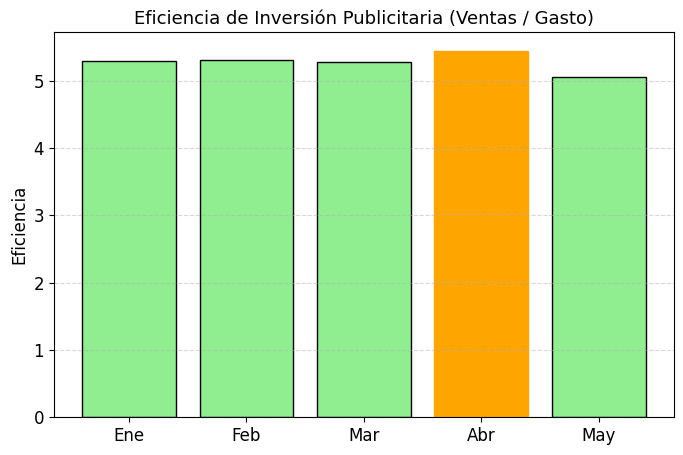

In [31]:
# =================================================
# 2️⃣ Identificar mes con mayor eficiencia (Ventas/Gasto_Publicidad)
# =================================================
df['Eficiencia'] = df['Ventas'] / df['Gasto_Publicidad']
mes_eficiente = df.loc[df['Eficiencia'].idxmax(), 'Mes']
valor_eficiencia = df['Eficiencia'].max()

print(f"\n🚀 Mes con mayor eficiencia: {mes_eficiente} "
      f"(Ventas/Gasto = {valor_eficiencia:.2f})")

plt.figure(figsize=(8,5))
bars = plt.bar(df['Mes'], df['Eficiencia'], color='lightgreen', edgecolor='black')
bars[df['Mes'].tolist().index(mes_eficiente)].set_color('orange')
plt.title('Eficiencia de Inversión Publicitaria (Ventas / Gasto)', fontsize=13)
plt.ylabel('Eficiencia')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()



⭐ Mes con mejor tasa de conversión: Mar (3.8%)

🧩 Análisis:
- Una tasa de conversión alta implica que una mayor proporción de visitantes realizó compras.
- No necesariamente coincide con el mes de mayores ventas totales.
- Factores posibles: mejor segmentación, promociones efectivas, o menos gasto con más impacto.


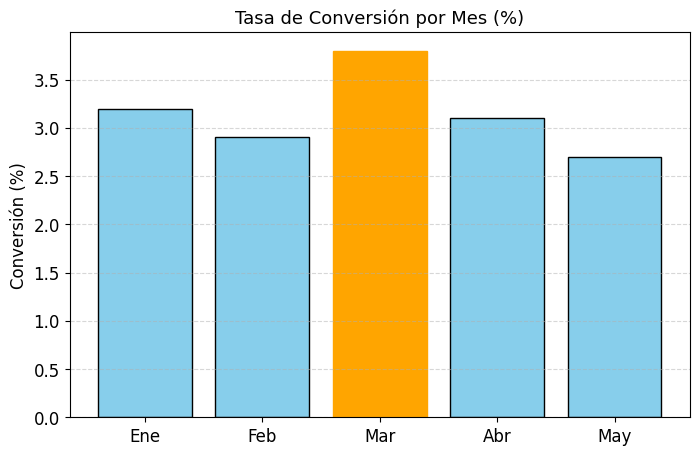

In [32]:
# =================================================
# 3️⃣ Determinar mes con mejor tasa de conversión y analizar causa
# =================================================
mes_conversion = df.loc[df['Conversion_%'].idxmax(), 'Mes']
valor_conversion = df['Conversion_%'].max()

print(f"\n⭐ Mes con mejor tasa de conversión: {mes_conversion} "
      f"({valor_conversion}%)")

print("\n🧩 Análisis:")
print("- Una tasa de conversión alta implica que una mayor proporción de visitantes realizó compras.")
print("- No necesariamente coincide con el mes de mayores ventas totales.")
print("- Factores posibles: mejor segmentación, promociones efectivas, o menos gasto con más impacto.")

plt.figure(figsize=(8,5))
bars = plt.bar(df['Mes'], df['Conversion_%'], color='skyblue', edgecolor='black')
bars[df['Mes'].tolist().index(mes_conversion)].set_color('orange')
plt.title('Tasa de Conversión por Mes (%)', fontsize=13)
plt.ylabel('Conversión (%)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


💰 Mes con mayor ticket promedio: Ene (Promedio de venta por producto = $100.00)


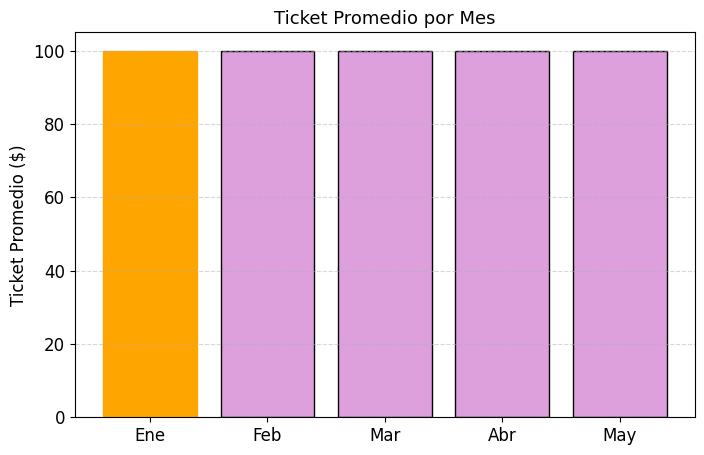

In [33]:
# =================================================
# 4️⃣ Calcular ticket promedio (Ventas / Productos_Vendidos)
# =================================================
df['Ticket_Promedio'] = df['Ventas'] / df['Productos_Vendidos']
mes_ticket_alto = df.loc[df['Ticket_Promedio'].idxmax(), 'Mes']
valor_ticket_alto = df['Ticket_Promedio'].max()

print(f"\n💰 Mes con mayor ticket promedio: {mes_ticket_alto} "
      f"(Promedio de venta por producto = ${valor_ticket_alto:,.2f})")

plt.figure(figsize=(8,5))
bars = plt.bar(df['Mes'], df['Ticket_Promedio'], color='plum', edgecolor='black')
bars[df['Mes'].tolist().index(mes_ticket_alto)].set_color('orange')
plt.title('Ticket Promedio por Mes', fontsize=13)
plt.ylabel('Ticket Promedio ($)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


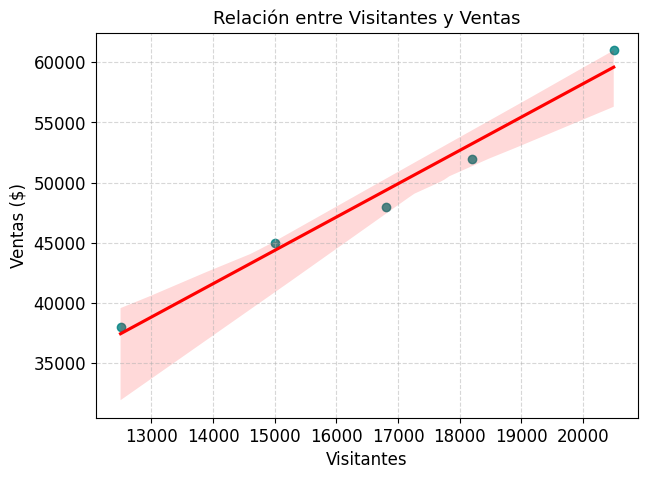


🔗 Correlación Visitantes–Ventas: 0.99

📊 Interpretación:
- Fuerte relación positiva: más visitantes generalmente implican más ventas.


In [34]:
# =================================================
# 5️⃣ Evaluar relación entre visitantes y ventas
# =================================================
plt.figure(figsize=(7,5))
sns.regplot(data=df, x='Visitantes', y='Ventas', color='teal', marker='o', line_kws={'color':'red'})
plt.title('Relación entre Visitantes y Ventas', fontsize=13)
plt.xlabel('Visitantes')
plt.ylabel('Ventas ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

corr = df['Visitantes'].corr(df['Ventas'])
print(f"\n🔗 Correlación Visitantes–Ventas: {corr:.2f}")

print("\n📊 Interpretación:")
if corr > 0.7:
    print("- Fuerte relación positiva: más visitantes generalmente implican más ventas.")
elif corr > 0.4:
    print("- Relación moderada: el tráfico ayuda, pero hay otros factores que influyen (precio, conversión, promoción).")
else:
    print("- Relación débil: la cantidad de visitantes no determina directamente las ventas.")

Conclusiones

- Mes más eficiente: Abril (Eficiencia = 5.45) → más ventas por cada peso invertido en publicidad.

- Mejor conversión: Marzo (3.8%) → mejor calidad de visitantes.

- Ticket promedio: $100 (constante).

- Correlación alta (0.99) → las ventas dependen fuertemente del número de visitantes.